# Performance on simulated protons and muons

In [1]:
%load_ext autoreload
%autoreload 2

import math
from itertools import product
import uproot
import awkward
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import matplotlib
matplotlib.rcParams.update({'font.size': 12})

from calo_likelihood import caloLikelihood
from helpers import *
from loaders import *
from initializers import *

In [2]:
today = '19_11_25'

In [3]:
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/proton_muon/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/proton_muon/pdfs/

In [4]:
save_folder = '/home/nic/Dropbox/MicroBooNE/_fig/' + today + '/proton_muon/'
save_folder_pdfs = save_folder + 'pdfs/'

In [5]:
branches = [
    'run',
    'sub',
    'evt',
    
    'backtracked_pdg',
    'backtracked_e',
    'backtracked_purity',
    'backtracked_completeness',
    'backtracked_overlay_purity',
    'backtracked_end_process',
    
    'backtracked_start_x',
    'backtracked_start_y',
    'backtracked_start_z',
    
    'backtracked_sce_start_x',
    'backtracked_sce_start_y',
    'backtracked_sce_start_z',
    
    'nplanehits_U',
    'nplanehits_V',
    'nplanehits_Y',
    'trk_score',

    'generation',
    'trk_daughters',
    'shr_daughters',

    'trk_sce_start_x',
    'trk_sce_start_y',
    'trk_sce_start_z',

    'trk_sce_end_x',
    'trk_sce_end_y',
    'trk_sce_end_z',
    
    'trk_theta',
    'trk_phi',

    'trk_dir_x',
    'trk_dir_y',
    'trk_dir_z',
    
    'trk_pid_chipr_u',
    'trk_pid_chipr_v',
    'trk_pid_chipr_y',
    'trk_pid_chimu_y',
    'trk_bragg_p_y',
    'trk_bragg_mu_y',
    'trk_bragg_p_three_planes',

    'trk_len',
    'longest',
    
    'dedx_u',
    'dedx_v',
    'dedx_y',

    'rr_u',
    'rr_v',
    'rr_y',

    'pitch_u',
    'pitch_v',
    'pitch_y',
    
#     'dir_x_u',
#     'dir_x_v',
#     'dir_x_y',
    
#     'dir_y_u',
#     'dir_y_v',
#     'dir_y_y',
    
#     'dir_z_u',
#     'dir_z_v',
#     'dir_z_y',
]

In [6]:
file_bnb = '~/Desktop/MicroBooNE/calorimetry_likelihood/v03/bnb_nu/out.root'

folder = "nuselection"
tree = "CalorimetryAnalyzer"

split_factor = 0.7
split_factor2 = 1
root_file = uproot.open(file_bnb)[folder][tree]
entry_split = int(len(root_file) * split_factor)
entry_split2 = int(len(root_file) * split_factor2)
array_train = root_file.arrays(branches, namedecode="utf-8", entrystop=entry_split)
array_test = root_file.arrays(branches, namedecode="utf-8", entrystart=entry_split, entrystop=entry_split2)

In [7]:
for array in [array_train, array_test]:
    initialisation_for_caloriemtry_data_mc(array)

In [8]:
def selection_for_train(array):
    return (array['backtracked_completeness'] > 0.9) &\
           (array['backtracked_purity'] > 0.9) &\
           (array['start_is_fiducial']) &\
           (array['end_is_fiducial']) &\
           (array['non_inelastic']) &\
           (array['trk_daughters']==0) &\
           (array['shr_daughters']==0)

def selection_for_test(array):
    return (array['start_is_fiducial']) &\
           (array['end_is_fiducial']) &\
           (array['trk_daughters']==0) &\
           (array['shr_daughters']==0)

def muon_for_test(array):
    return selection_for_test(array) & (np.abs(array['backtracked_pdg'])==13)

def proton_for_test(array):
    return selection_for_test(array) & (np.abs(array['backtracked_pdg'])==2212)

def cosmic_for_test(array):
    return selection_for_test(array) & (np.abs(array['backtracked_pdg'])==0)

def selection_planes(array):
    aux = []
    for plane in ['_u', '_v', '_y']:
        aux.append(array['first_last_hit_mask'+plane])
    return aux

In [9]:
selection_train = selection_for_train(array_train)
selection_train_planes = selection_planes(array_train)
selection_test = selection_for_test(array_test)
selection_test_planes = selection_planes(array_test)

In [10]:
parameters_names = ['rr', 'pitch']
parameters_bin_edges = [[0., 2, 4, 7, 10, 15, 20, 30, 50, 100, 300, 2000],
                  [.0, 0.6, 1, 1.5, 3, 30]]

dedx_var = 'dedx'
dedx_bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 9, 10, 12, 15, 20, 25, 30, 35, 40, 45, 50]

parameters = []
dedx_vars = []
for plane in ['u', 'v', 'y']:
    parameters.append([parameter_name+'_'+plane for parameter_name in parameters_names])
    dedx_vars.append(dedx_var+'_'+plane)

pdgcode_var = 'backtracked_pdg'

In [11]:
caloLike_train = caloLikelihood(array_train, quality_mask=selection_train, quality_masks_planes=selection_train_planes)
caloLike_test = caloLikelihood(array_test, quality_mask=selection_test, quality_masks_planes=selection_test_planes)

caloLike_train.setPdgCodeVar(pdgcode_var)
caloLike_test.setPdgCodeVar(pdgcode_var)

In [12]:
for i in [0, 1, 2]:
    caloLike_train.setVariablesBinning(i, parameters[i], parameters_bin_edges, dedx_vars[i], dedx_bins)
    caloLike_train.buildLookUpTableMC(i, 13)    
    caloLike_train.buildLookUpTableMC(i, 2212)    
    caloLike_train.buildLookUpLogLikelihoodRatio(i, [13, 2212])
    caloLike_test.setVariablesBinning(i, parameters[i], parameters_bin_edges, dedx_vars[i], dedx_bins)

/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:129: RuntimeWarning: invalid value encountered in true_divide
  hist_total/hist_partial[..., np.newaxis],
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:140: RuntimeWarning: divide by zero encountered in log
  np.log(table_1) - np.log(table_2),
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:140: RuntimeWarning: invalid value encountered in subtract
  np.log(table_1) - np.log(table_2),


In [13]:
caloLike_train.addCalorimetryVariables(caloLike_test.array, pdg_codes=[13, 2212], cali=False)
caloLike_train.addCalorimetryVariablesFromLLRTable(caloLike_test.array, selection_test_planes, cali=False)

/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:245: RuntimeWarning: divide by zero encountered in log
  return np.log(self.lookup_tables[pdg_code][plane_num][lookup_index])
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:292: RuntimeWarning: invalid value encountered in subtract
  array['log_like_ratio_{}'.format(plane)] = array['like_{}_sum_{}'.format(pdg_codes[0], plane)] - array['like_{}_sum_{}'.format(pdg_codes[1], plane)]
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:294: RuntimeWarning: invalid value encountered in add
  array['log_like_ratio'] = array['log_like_ratio_0'] + array['log_like_ratio_1'] + array['log_like_ratio_2']
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:295: RuntimeWarning: invalid value encountered in add
  array['log_like_ratio_01'] = array['log_like_ratio_0'] + array['log_like_ratio_1']


In [14]:
# caloLike_train.printCplusplusCode(filename='/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/calorimetry_likelihood/larsoft_dev/LLRPID_proton_muon_lookup.h', planes=[0, 1, 2])

In [15]:
caloLike_train.logLikelihoodRatioOneHit(2, 2.5, [27, 4])

-0.26331808708734084

## Plot of the pdfs/likelihoods in bins of residual range and pitch

### Plot PDFs from lookup tables

In [46]:
for plane_num in [0, 1, 2]:
    bin_centers = product(*caloLike_train.parameters_bin_centers[plane_num])
    for bin_center in bin_centers:
        caloLike_train.plotLookUpDedxMC(plane_num=plane_num, 
                                  pdg_code=13, 
                                  parameters_value=bin_center, 
                                  label='muon')
        caloLike_train.plotLookUpDedxMCfancy(plane_num=plane_num, 
                                  pdg_code=2212, 
                                  parameters_value=bin_center, 
                                  label='proton')
        plt.xlim(0, 30)
        plt.tight_layout()
        plt.savefig(save_folder_pdfs+'plane_{}_rr_{}_pitch_{}.png'.format(plane_num, bin_center[0], bin_center[1]), dpi=250)
        plt.close()

## Plots

In [14]:
def add_norm_variable(array, var, scale=100):
    array[var+'_n'] = 2/math.pi*np.arctan(array[var]/scale)

In [15]:
interesting_variables = ['trk_pid_chipr_y',
                         'trk_pid_chimu_y',
                         'trk_bragg_p_y',
                         'trk_bragg_mu_y',
                         'trk_bragg_p_three_planes',
#                          'llr_sum_0',
#                          'llr_sum_1',
                         'llr_sum_2',
                         'llr_01',
                         'llr_012',
                        ]

variable_labels = {
    'trk_pid_chipr_y': '$\chi^2_{proton}$ Y',
    'trk_pid_chimu_y': '$\chi^2_{\mu}$ Y',
    'trk_bragg_p_y': 'Bragg likelihood proton Y',
    'trk_bragg_mu_y': 'Bragg likelihood muon Y',
    'trk_bragg_p_three_planes': 'Bragg likelihood proton UVY',
    'llr_sum_0': 'LLR U',
    'llr_sum_1': 'LLR V',
    'llr_sum_2': 'LLR Y',
    'llr_01': 'LLR UV',   
    'llr_012': 'LLR UVY',   
}

for variable in interesting_variables:
    if 'llr' in variable:
        scale = 100
    elif 'bragg' in variable:
        scale = 1
    else:
        scale = 10
    add_norm_variable(caloLike_test.array, variable, scale)

In [16]:
bins = 41
range = [-1, 1]
kwargs = {'histtype':'step'}
for var in interesting_variables:
    variable = var + '_n'
    caloLike_test.plotVariableMC(variable, bins, range, function_mask=proton_for_test, quality_mask=True, label='proton', **kwargs);
    caloLike_test.plotVariableMC(variable, bins, range, function_mask=muon_for_test, quality_mask=True, label='muon', **kwargs);
    caloLike_test.plotVariableMCFancy(variable, bins, range, function_mask=cosmic_for_test, quality_mask=True, label='cosmic', **kwargs);
    plt.xlabel(variable_labels[var])
    plt.tight_layout()
    plt.savefig(save_folder + variable + '.png', dpi=250)
    plt.close()

## ROC curves

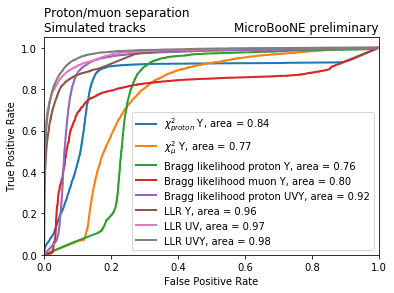

In [17]:
for variable in interesting_variables:
    caloLike_test.rocCurve(variable=variable+'_n', 
         pdg_codes=[13, 2212], 
         plot=True,
         variable_label=variable_labels[variable])

plt.title('Proton/muon separation\nSimulated tracks', loc='left')
plt.savefig(save_folder + 'roc_curves.png', dpi=250)

In [18]:
def selection_function(array, parameter, bin_range):
    return (array[parameter] >= bin_range[0]) &\
           (array[parameter] < bin_range[1])

pdg_codes = [13, 2212]
interesting_variables = ['trk_pid_chipr_y',
                         'trk_bragg_p_three_planes',
                         'trk_bragg_p_y',
                         'llr_01',
                         'llr_sum_2',
                         'llr_012',
                        ]
parameter_name = 'trk_theta'
parameter_bin_edges = np.linspace(0, np.pi, 20)

for variable in interesting_variables:
    caloLike_test.auc1D(variable+'_n', 
                        pdg_codes, 
                        selection_function, 
                        parameter_name, 
                        parameter_bin_edges,
                        legend_label=variable_labels[variable])
    
plt.xlabel(r'Track $\theta$')
plt.legend()
plt.title('Proton/muon separation\nSimulated tracks', loc='left')
plt.tight_layout()
plt.savefig(save_folder+'auc1d'+parameter_name+'.png', dpi=250)
plt.close()

In [19]:
def selection_function(array, parameter, bin_range):
    return (array[parameter] >= bin_range[0]) &\
           (array[parameter] < bin_range[1])

pdg_codes = [13, 2212]
interesting_variables = ['trk_pid_chipr_y',
                         'trk_bragg_p_three_planes',
                         'trk_bragg_p_y',
                         'llr_01',
                         'llr_sum_2',
                         'llr_012',
                        ]
parameter_name = 'trk_phi'
parameter_bin_edges = np.linspace(-np.pi, np.pi, 20)

for variable in interesting_variables:
    caloLike_test.auc1D(variable+'_n', 
                        pdg_codes, 
                        selection_function, 
                        parameter_name, 
                        parameter_bin_edges,
                        legend_label=variable_labels[variable])
    
plt.xlabel(r'Track $\phi$')
plt.legend()
plt.title('Proton/muon separation\nSimulated tracks', loc='left')
plt.tight_layout()
plt.savefig(save_folder+'auc1d'+parameter_name+'.png', dpi=250)
plt.close()

In [20]:
def selection_function(array, parameters_names, bin_ranges):
    return (array[parameters_names[0]] >= bin_ranges[0][0]) &\
           (array[parameters_names[0]] < bin_ranges[0][1]) &\
           (array[parameters_names[1]] >= bin_ranges[1][0]) &\
           (array[parameters_names[1]] < bin_ranges[1][1])

pdg_codes = [13, 2212]

parameters_names = ['trk_theta', 'trk_phi']
parameter_bin_edges = (np.linspace(0, np.pi, 6), np.linspace(-np.pi, np.pi, 10))

for variable in interesting_variables:
    caloLike_test.auc2D(variable+'_n', 
                            pdg_codes, 
                            selection_function, 
                            parameters_names, 
                            parameter_bin_edges)

    plt.xlabel(r'Track $\theta$')
    plt.ylabel(r'Track $\phi$')
    plt.title('Proton/muon separation\nSimulated tracks\nArea Under the Roc Curve\n'+variable_labels[variable]+'\n', loc='left')
    plt.tight_layout()
    plt.savefig(save_folder+'auc2d'+variable+'.png', dpi=250)
    plt.close()